# Practice

### Problem

Inn the Neighborhood is an online platform that allows people to rent out their properties for short stays. At the moment, only 2% of people who come to the site interested in renting out their homes start to use it.

The product manager would like to increase this. They want to develop an application to help people estimate how much they could earn renting out their living space. They hope that this would make people more likely to sign up.



### Question

The product manager would like to know:
- Can you develop a way to predict how much someone could earn from renting their property that could power the application?




### Success Criteria

They want to avoid estimating prices that are more than 25 dollars off of the actual price, as this may discourage people.


### Dataset

The data you will use for this analysis can be accessed here: `"data/rentals.csv"`

# Data Validation
This data set has 8,111 rows and 9 columns. I validated all the variables. 
All of the columns are as described in the data dictionary:
* id - numeric, the unique identification number of the property
* latitude - numeric, the latitude of the property
* longitude - numeric, the longitude of the property
* property_type - character, the type of property. There are 26 different property types.
* room_type - character, the type of room. There are 4 different room types. 
* bathrooms - numeric, the number of bathrooms. 
* bedrooms - numeric, the number of bedrooms
* minimum_nights - numeric, the minimum number of nights someone can book
* price, character, the dollars per night charged. I changed this variable to numeric.

Since there were only a few missing values, I chose only complete observations, and thus dropped rows with NAs (16 rows total or ~.2% of the original dataset).


In [1]:
#import packages needed for the analysis
installed.packages("tidyverse")
install.packages("mapview")
install.packages("sf")
install.packages("maps")
install.packages("patchwork")
install.packages("glmnet")
install.packages("mltools")
install.packages("data.table")
install.packages("xgboost")




Package,LibPath,Version,Priority,Depends,Imports,LinkingTo,Suggests,Enhances,License,License_is_FOSS,License_restricts_use,OS_type,Archs,MD5sum,NeedsCompilation,Built


Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/mapview_2.11.0.tar.gz' ...
	OK [downloaded 2.3 Mb in 0.8 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/leafem_0.2.0.tar.gz' ...
	OK [downloaded 3.3 Mb in 0.6 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/leaflet_2.1.1.tar.gz' ...
	OK [downloaded 2.2 Mb in 0.6 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/viridis_0.6.2.tar.gz' ...
	OK [downloaded 2.9 Mb in 0.1 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/leaflet.providers_1.9.0.tar.gz' ...
	OK [downloaded 46.1 Kb in 0.5 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/leafpop_0.1.0.tar.gz' ...
	OK [downloaded 1.8 Mb in 0.5 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/satellite_1.0.4

In [2]:
library(readr)
library(tidyr)
library(dplyr)
#read in data, change the output variable - price - to numeric and drop NAs
df <-  read_csv("data/rentals.csv") %>% dplyr::mutate(price = parse_number(price)) %>% drop_na()

#display summary of data
summary(df)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Rows: 8111 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): property_type, room_type, price
dbl (6): id, latitude, longitude, bathrooms, bedrooms, minimum_nights

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


       id              latitude       longitude      property_type     
 Min.   :     958   Min.   :37.70   Min.   :-122.5   Length:8095       
 1st Qu.: 8933734   1st Qu.:37.75   1st Qu.:-122.4   Class :character  
 Median :21619241   Median :37.77   Median :-122.4   Mode  :character  
 Mean   :20266981   Mean   :37.77   Mean   :-122.4                     
 3rd Qu.:31200254   3rd Qu.:37.79   3rd Qu.:-122.4                     
 Max.   :39354181   Max.   :37.83   Max.   :-122.4                     
  room_type           bathrooms         bedrooms      minimum_nights     
 Length:8095        Min.   : 0.000   Min.   : 0.000   Min.   :        1  
 Class :character   1st Qu.: 1.000   1st Qu.: 1.000   1st Qu.:        2  
 Mode  :character   Median : 1.000   Median : 1.000   Median :        4  
                    Mean   : 1.396   Mean   : 1.346   Mean   :    12370  
                    3rd Qu.: 1.500   3rd Qu.: 2.000   3rd Qu.:       30  
                    Max.   :14.000   Max.   :14.000 

In [3]:
#Validate property_type
df$property_type <- as.factor(df$property_type)
unique(df$property_type)
length(unique(df$property_type))

[1] Apartment          House              Condominium        Townhouse         
 [5] Loft               Guest suite        Cottage            Hostel            
 [9] Guesthouse         Serviced apartment Bungalow           Bed and breakfast 
[13] Hotel              Boutique hotel     Other              Tiny house        
[17] Resort             Villa              Aparthotel         Castle            
[21] Camper/RV          In-law             Earth house        Cabin             
[25] Dome house         Hut               
26 Levels: Aparthotel Apartment Bed and breakfast Boutique hotel ... Villa

[1] 26

In [4]:
#Validate room_type
df$room_type <- as.factor(df$room_type)
unique(df$room_type)

[1] Entire home/apt Private room    Shared room     Hotel room     
Levels: Entire home/apt Hotel room Private room Shared room

# Exploratory Analysis

## Target Variable - Price
We are attempting to predict price. The price data is skewed and using a log transformation gets it closer to a normal distribution.  




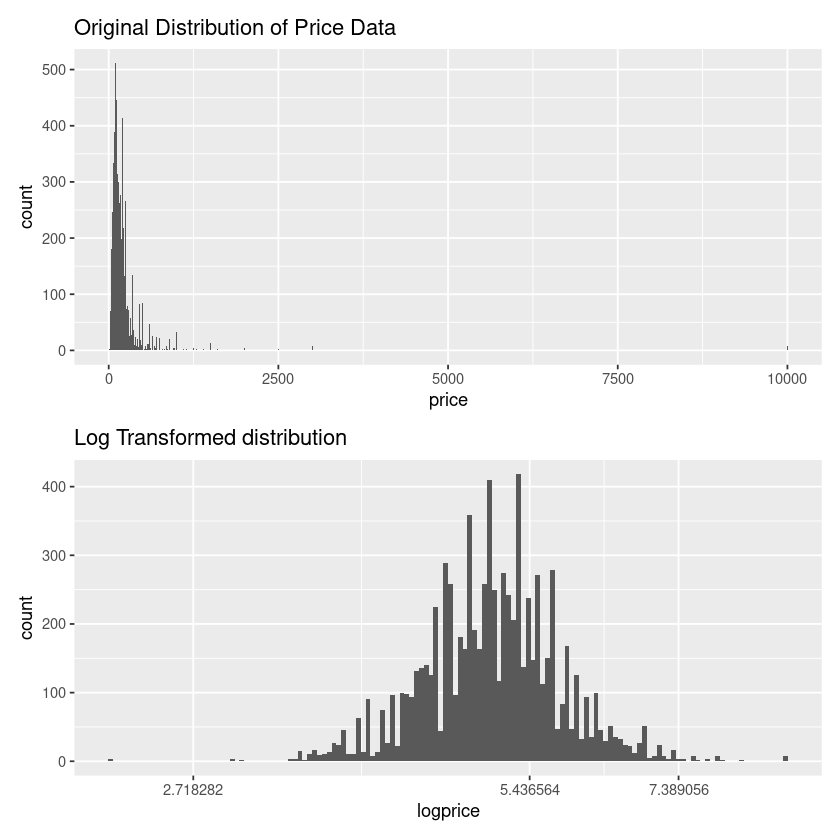

In [5]:
library(ggplot2)
library(patchwork)
#Plot distirbution of price
p1 <- ggplot(df, aes(price))+geom_histogram(binwidth = 10) + ggtitle("Original Distribution of Price Data")
#Log transform the data
dftransformed <- df[df$price> 0,]
dftransformed$logprice <- log(dftransformed$price)
#plot the log transformed data
p2 <- ggplot(dftransformed, aes(logprice))+geom_histogram(binwidth = .01)+scale_x_continuous(trans = 'log') + ggtitle("Log Transformed distribution")
p1/p2



### Check relationship between the price variable and predictor variables
I examined the relationship between the response and predictor variables. 

,latitude,longitude,bathrooms,bedrooms,minimum_nights,logprice
latitude,1.000000000,0.187055617,0.078424566,-0.108696737,-0.007417145,0.15883814
longitude,0.187055617,1.000000000,0.007647749,-0.115877332,0.002028239,0.05216553
bathrooms,0.078424566,0.007647749,1.000000000,0.327902824,-0.004766882,0.06006024
bedrooms,-0.108696737,-0.115877332,0.327902824,1.000000000,-0.004159552,0.52729624
minimum_nights,-0.007417145,0.002028239,-0.004766882,-0.004159552,1.000000000,-0.01327970
logprice,0.158838142,0.052165532,0.060060237,0.527296240,-0.013279696,1.00000000


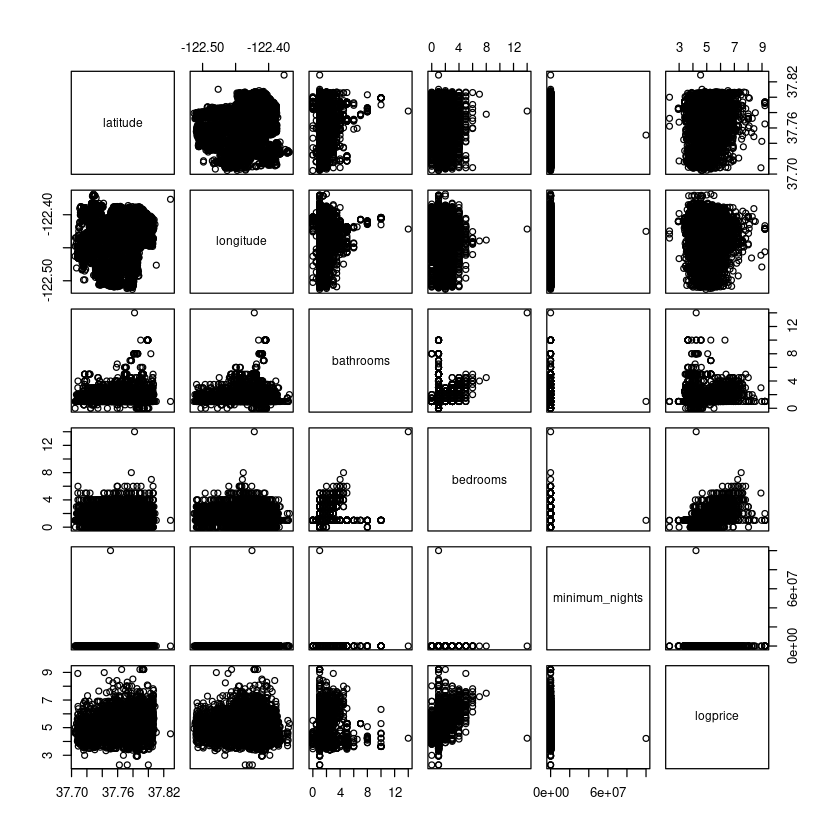

In [6]:
plot(dftransformed[, c('latitude', 'longitude', 'bathrooms', 'bedrooms', 'minimum_nights', 'logprice')])
cor(dftransformed[, c('latitude', 'longitude', 'bathrooms', 'bedrooms', 'minimum_nights', 'logprice')], use = "complete.obs")

### Latitude and longitude data
I originally mapped the latitude and longitude data to see, generally, where the properties were located. It appears they are located in the Bay Area. It's possible to do some dimension reduction techniques using reverse geocoding, but since the locations are in the same area (and thus the earth's curature isn't of a great concern), I created several main clusters using kmeans. 

Installing maps [3.4.1] ...
	OK [linked cache]


Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1; sf_use_s2() is TRUE



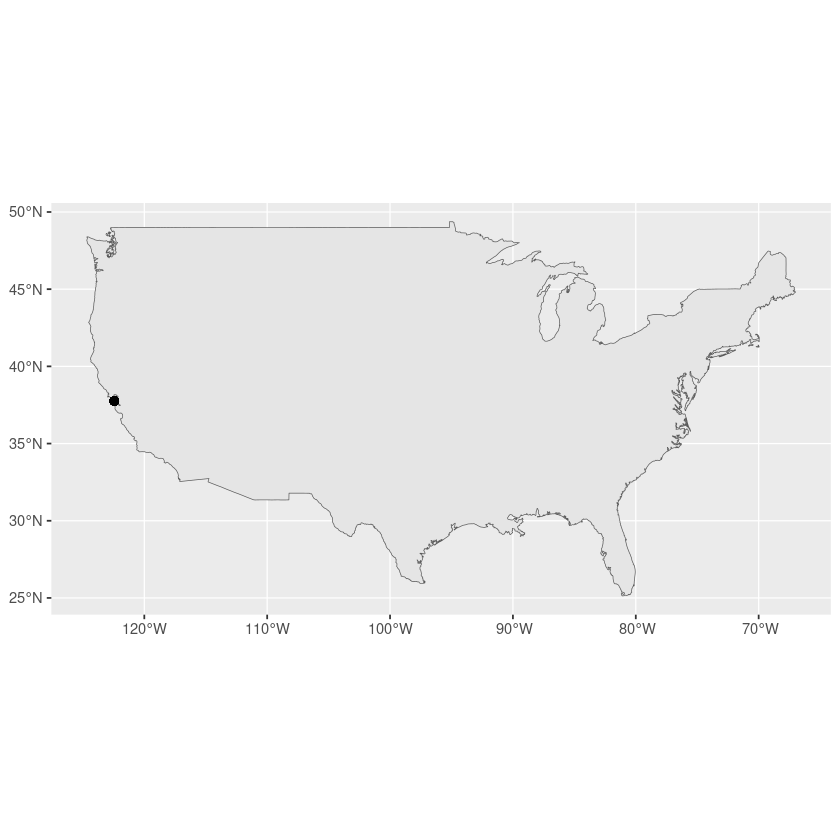

In [7]:
# Plotting the lat/longs to get a sense of where the properties are located
library(dplyr)
install.packages("maps")
library(maps)
library(ggplot2)
library(sf)
df_location <- df %>% dplyr::select("latitude", "longitude")
df_sf <- st_as_sf(df_location, coords = c("longitude", "latitude"), agr = "constant", crs = 4326)
usa <- st_as_sf(map('usa', plot = FALSE), crs = 4326)
ggplot() +
geom_sf(data = usa)+
geom_sf(data = df_sf)


Attaching package: ‘purrr’


The following object is masked from ‘package:maps’:

    map




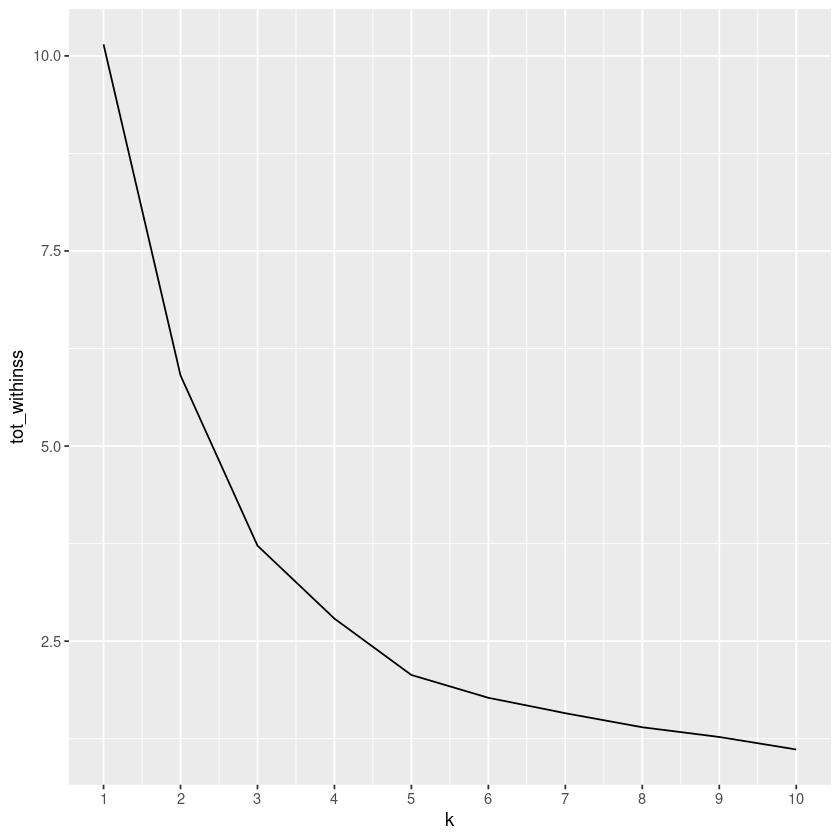

In [8]:
#create clusters of lat/long data
library(purrr)
library(dplyr)
library(ggplot2)
df_cluster <- df[,2:3]
# Using map_dbl to run many models with varying value of k (centers)
tot_withinss <- map_dbl(1:10,  function(k){
  model <- kmeans(x = df_cluster, centers = k)
  model$tot.withinss
})
# Generate a data frame containing both k and tot_withinss
elbow_df <- data.frame(
  k = 1:10 ,
  tot_withinss = tot_withinss
)
# Plot the elbow plot to see which value of K to use
ggplot(elbow_df, aes(x = k, y = tot_withinss)) +
  geom_line() +
  scale_x_continuous(breaks = 1:10)

### Assign locations to clusters
Based on the elbow plot above it looks most of the reduction of tot_withinss occurs by 5 clusters so I assigned each of the properties to one of 5 clusters. 

In [9]:
library(dplyr)
set.seed(10)
#create clusters
df_cluster_assignment <- dftransformed[,2:3]
latlong_model <- kmeans(df_cluster_assignment, centers = 5)
clusters <- as.factor(latlong_model$cluster)
dfloc <- mutate(dftransformed, location = clusters) 

### Check distribution of bathrooms and bedrooms
Since bathrooms and bedrooms were the most correlated to price, let's check their distribution. As was showing in the correlation matrix, number of bedrooms appears to be somewhat correlated to the price. 

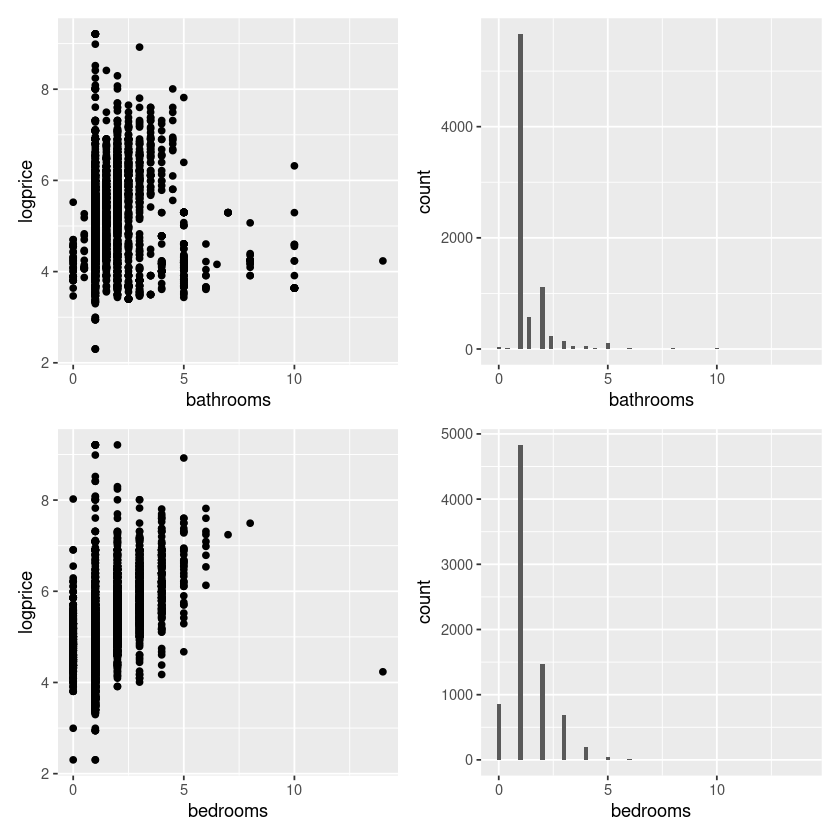

In [10]:
library(ggplot2)
p3_1 <- ggplot(dfloc, aes(bathrooms))+geom_histogram(binwidth = .2)
p3 <- ggplot(dfloc, aes(bathrooms, logprice))+geom_point()
p4_1 <- ggplot(dfloc, aes(bedrooms)) + geom_histogram(binwidth = .2)
p4 <- ggplot(dfloc, aes(bedrooms, logprice))+geom_point()
(p3+p3_1)/(p4+p4_1)


### Plot numerical variables where there isn't a linear relationship.
I plotted property_type vs. price and appears there are clustes in the minimum nights variable, so I created a new categorical variable. I'd need some more direction on this, but it seems that Inn the Neighborhood is interested in renters who are willing to rent on a shortterm basis. It might make sense, for a future iteration of the application, to screen out applications who have a minimum night requirement longer than Inn the Neighborhood's preference.

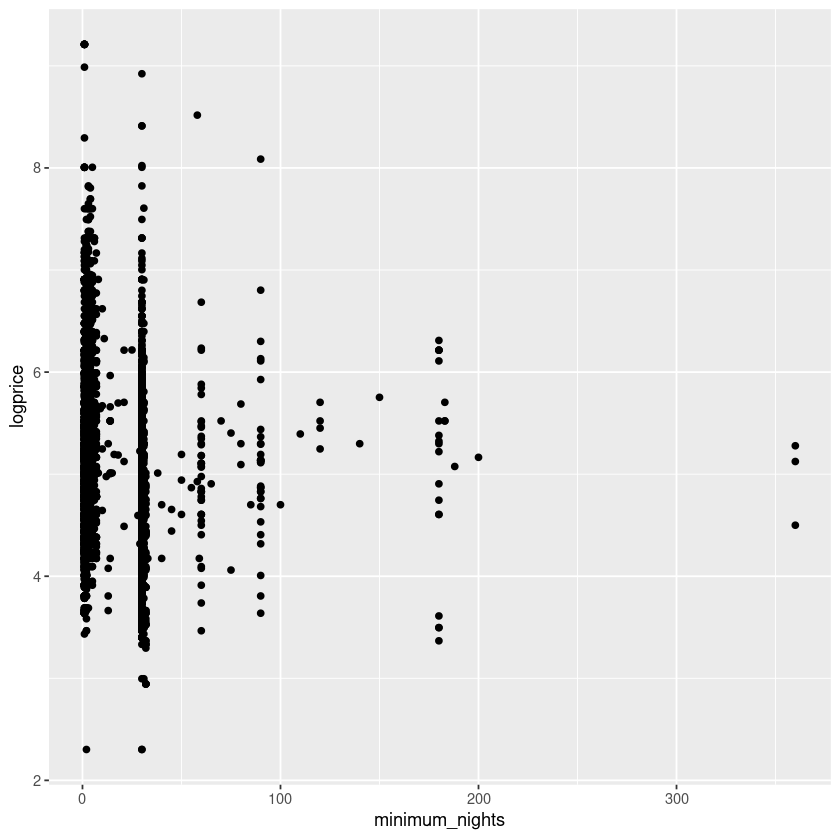

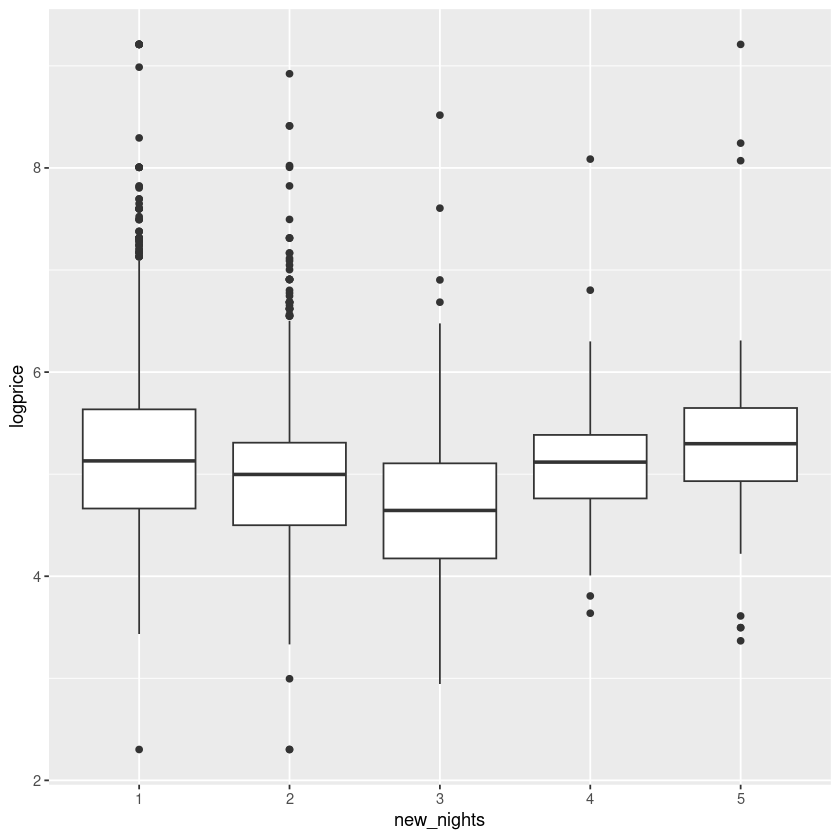

In [11]:
library(ggplot2)
library(dplyr)
#Plot minimum nights vs transformed price
dfloc %>% filter(minimum_nights <365) %>% ggplot(aes(minimum_nights, logprice)) + geom_point()
dfnights <- dfloc %>% mutate(new_nights = case_when(
    minimum_nights < 7  ~ 1, 
    minimum_nights >= 7 & minimum_nights < 31 ~ 2, 
    minimum_nights >= 31 & minimum_nights < 61 ~ 3,
    minimum_nights >= 61 & minimum_nights < 91 ~ 4,
	TRUE ~ 5)) 
dfnights$new_nights <- as.factor(dfnights$new_nights)

dfnights %>% ggplot(aes(new_nights, logprice, group = new_nights)) + geom_boxplot() 



### Relationship between property type and room type (categorical variables)
There's a relationshipe between the room type and the price, but, the property type variables are all over the place. To reduce levels slightly, I created a new variable, new_prop, which lumped the property types that had a count of less than ten into the "Other" category. 

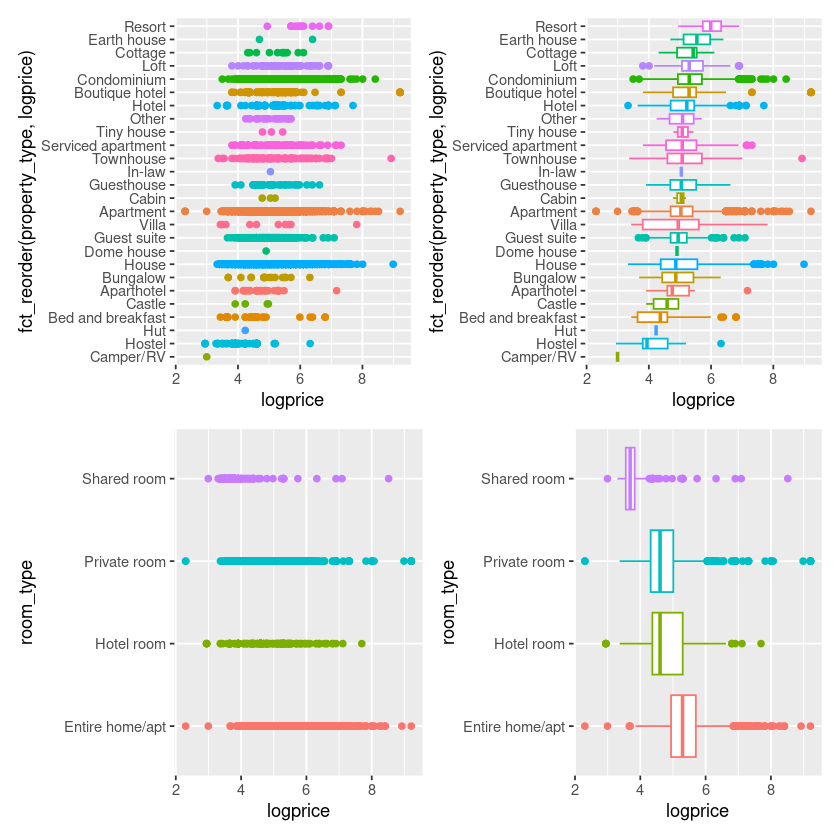

In [12]:
library(ggplot2)
library(patchwork)
library(forcats)
library(dplyr)
p5 <- ggplot(dfnights, aes(fct_reorder(property_type,logprice), logprice, color = property_type)) + geom_point()+coord_flip()+theme(legend.position = "none")
p6 <- ggplot(dfnights, aes(room_type, logprice, color = room_type)) + geom_point()+coord_flip()+theme(legend.position = "none")

p7 <- ggplot(dfnights, aes(fct_reorder(property_type,logprice), logprice, color = property_type)) + geom_boxplot() +coord_flip() +theme(legend.position = "none")
p8 <- ggplot(dfnights, aes(room_type, logprice, color = room_type)) + geom_boxplot() +coord_flip()+theme(legend.position = "none")
(p5 + p7)/(p6 + p8)
dfprop <- dfnights %>% group_by(property_type) %>% mutate(count = n()) %>% ungroup() %>% mutate(new_prop = ifelse(count < 10 | property_type == "Other", "Other", property_type))%>%select(-property_type, -count)
dfprop$new_prop <- as.factor(dfprop$new_prop)



# Model Fitting and Evaluation
The goal is to predict the price, which is a regression project. I'm starting with a linear regression model to learn more about the relation between the response and predictor variables.


### Prepare data for modeling

* Remove extreme outliers
* Scale the numerical variables
* Split data into a training and test set
* Perform one hot encoding of categorical variables

In [13]:
#removed outliers greater than 3 SD
dffinal <- dfprop %>% filter(price < (mean(price)+3*sd(price)))

In [14]:
library(mltools)
library(dplyr)
library(data.table)
#drop unneeded variables and scale numerical variables
df_model <- setDT(dffinal %>% select(-c(id,latitude,longitude, minimum_nights, price))%>% mutate_at(c("bathrooms","bedrooms"), funs(c(scale(.)))))

#not encoded data
set.seed(10)
smp_size <- floor(0.7 * nrow(df_model))
train_ind <- sample(seq_len(nrow(df_model)), size = smp_size)

train_model <- df_model[train_ind, ]
test_model <- df_model[-train_ind, ]

df_encoded <- one_hot(df_model, dropCols = TRUE)


## 70 of the sample size
smp_size_enc <- floor(0.7 * nrow(df_encoded))

## set the seed to make reproducible
set.seed(10)
train_ind <- sample(seq_len(nrow(df_encoded)), size = smp_size_enc)

train <- data.matrix(df_encoded[train_ind, ] %>% select(-logprice))
train_label <- data.matrix(df_encoded[train_ind, ] %>% select(logprice))
test <- data.matrix(df_encoded[-train_ind, ] %>% select(-logprice))
test_label <- data.matrix(df_encoded[-train_ind, ] %>% select(logprice))



Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na



Attaching package: ‘data.table’


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:dplyr’:

    between, first, last


Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


In [17]:
library(ggplot2)
#try it with regular regression - adding in one variable at a time) 
models <- list(
model1 <- lm(logprice ~ new_prop + room_type, data = train_model),
model2 <- lm(logprice ~ new_prop + room_type + bathrooms, data = train_model),
model3 <- lm(logprice ~ new_prop + room_type + bathrooms+bedrooms, data = train_model),
model4 <- lm(logprice ~ new_prop + room_type + bathrooms+bedrooms + location, data = train_model),
model5 <- lm(logprice ~ new_prop+room_type+bathrooms+bedrooms+location+new_nights+room_type, data = train_model))

names(models) <- c("model1", "model2", "model3", "model4", "model5")

#rsme for each matrix
rmse <- data.frame()
for (i in 1:5) {
    name <- paste0("model",i)
    temp <- data.frame(rmse = sqrt(mean(models[[name]]$residuals^2)))
    rmse <- rbind(rmse, temp)
    }


#% predicted within $25 for each model
results <- data.frame()
for(i in 1:5) {
name <- paste0("model",i)
prediction <- predict(models[[name]], new = test_model)
difference <- abs(exp(prediction) - exp(test_model$logprice))
correct <- ifelse(difference < 25, 1, 0)
percent <- sum(correct)/length(prediction)
temp <- data.frame(name, percent = percent)
results <- rbind(results, temp)

   }

output <- cbind(rmse, results)
rmse
results



rmse
<dbl>
0.5325095
0.5250759
0.4666448
0.4574998
0.4295210


name,percent
<chr>,<dbl>
model1,0.2767635
model2,0.2813278
model3,0.3336100
model4,0.3302905
model5,0.3726141


### Plot the RSME and % Within $25
I created 5 regression models in a sort of manual stepwise selection process to see the impact of each variable. Model one had just property and room type, model two included bathroom, model three included bedrooms, model four included location, and model five included new minimum nights variable. The model gets progressively better in both RMSE and percent predicted within 25 dollars. But, the best model only predicted 37 percent within 25 dollars. 


Warning message in geom_label(label = name, nudge_x = 0.01, nudge_y = 0.01, check_overlap = T):
“Ignoring unknown parameters: `check_overlap`”


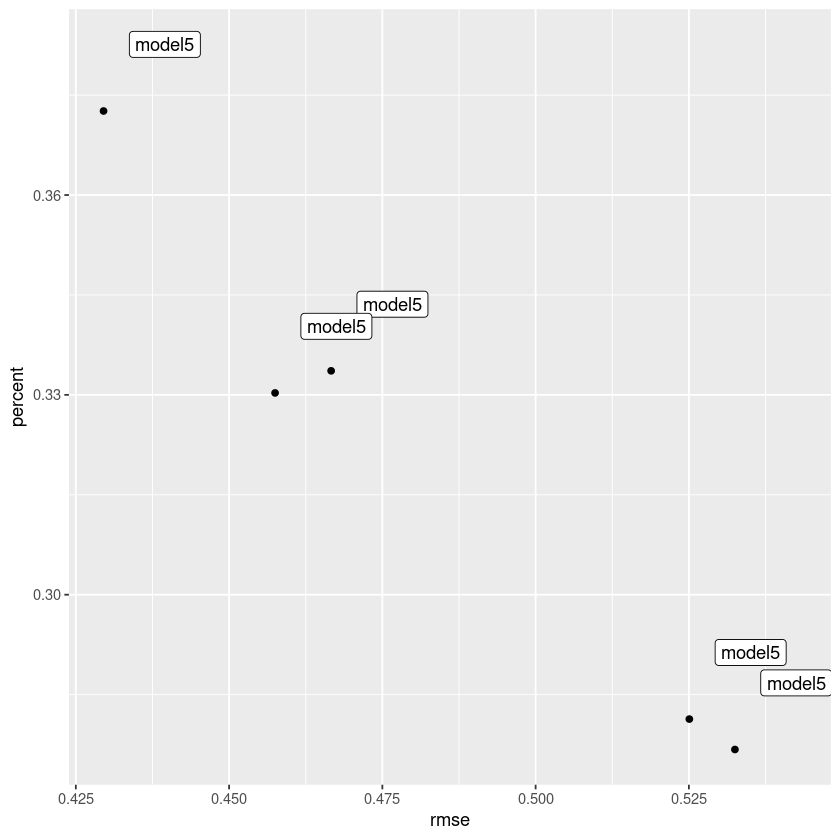

In [25]:
library(ggplot2)

ggplot(output, aes(rmse, percent)) + geom_point()+
geom_label(
    label=name, 
    nudge_x = 0.01, nudge_y = 0.01, 
    check_overlap = T
  )

### Comparison model - xgboost
Given the varibility in the data, I'm going to try xgboost. The boosted decision tree approach of the model might improve the predictive power of the model. 
xgboost has a nround parameter that I tuned initially. 


In [26]:
library(xgboost)
#set up data for xgboost
xbtrain <- xgb.DMatrix(data = train, label = train_label) 
xbtest <- xgb.DMatrix(data = test,label= test_label)
#check the number of rounds needed
xgbcv <- xgb.cv(data = xbtrain, nrounds = 200, nfold = 5, showsd = T, stratified = T, print.every.n = 10, early.stop.round = 20, maximize = F, max_depth = 6)


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Warning message:
“'print.every.n' is deprecated.
Use 'print_every_n' instead.
See help("Deprecated") and help("xgboost-deprecated").”
Warning message:
“'early.stop.round' is deprecated.
Use 'early_stopping_rounds' instead.
See help("Deprecated") and help("xgboost-deprecated").”


[1]	train-rmse:3.242854+0.002315	test-rmse:3.243346+0.011263 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 20 rounds.

[11]	train-rmse:0.399237+0.005811	test-rmse:0.420557+0.023238 
[21]	train-rmse:0.376594+0.005888	test-rmse:0.407447+0.023705 
[31]	train-rmse:0.370698+0.005349	test-rmse:0.407596+0.023872 
[41]	train-rmse:0.366536+0.005071	test-rmse:0.408599+0.023115 
Stopping. Best iteration:
[27]	train-rmse:0.372454+0.005325	test-rmse:0.406790+0.023350



In [27]:
#train model
library(xgboost)
boost_model <- xgboost(data = xbtrain, nrounds = 27, eta = 1)



[1]	train-rmse:0.464708 
[2]	train-rmse:0.432208 
[3]	train-rmse:0.422080 
[4]	train-rmse:0.405659 
[5]	train-rmse:0.397034 
[6]	train-rmse:0.386164 
[7]	train-rmse:0.384834 
[8]	train-rmse:0.381200 
[9]	train-rmse:0.376552 
[10]	train-rmse:0.374636 
[11]	train-rmse:0.372246 
[12]	train-rmse:0.369015 
[13]	train-rmse:0.367217 
[14]	train-rmse:0.366042 
[15]	train-rmse:0.365799 
[16]	train-rmse:0.365408 
[17]	train-rmse:0.364790 
[18]	train-rmse:0.364148 
[19]	train-rmse:0.363198 
[20]	train-rmse:0.362520 
[21]	train-rmse:0.361810 
[22]	train-rmse:0.361108 
[23]	train-rmse:0.360803 
[24]	train-rmse:0.360357 
[25]	train-rmse:0.360145 
[26]	train-rmse:0.359522 
[27]	train-rmse:0.358882 


[1] 33.53746

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
bedrooms,0.5154253278,0.177987486,0.168168168
room_type_Entire home/apt,0.1239802918,0.032640492,0.060060060
new_nights_1,0.1053759690,0.025847554,0.063063063
bathrooms,0.0744411062,0.190363049,0.203203203
room_type_Shared room,0.0253335102,0.028159877,0.020020020
location_3,0.0222208291,0.016702098,0.038038038
location_1,0.0149921926,0.015178041,0.040040040
new_prop_9,0.0144107838,0.028443475,0.026026026
location_2,0.0130477684,0.030337101,0.031031031


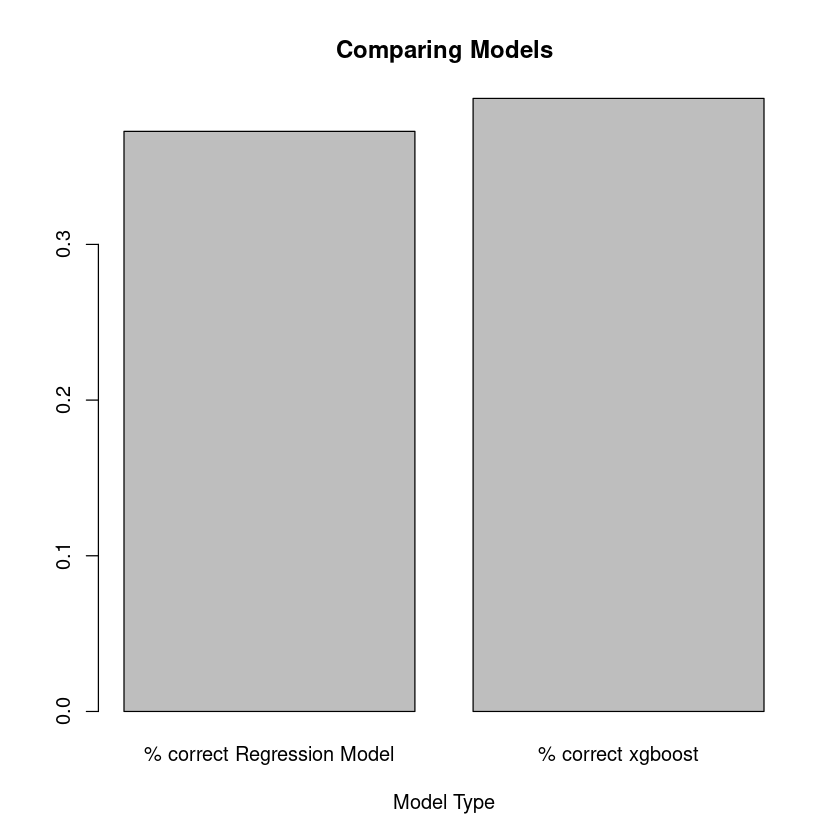

In [30]:
#check how the model did and plot % correct of the two models. 
prediction <-predict(boost_model, new = xbtest)
difference <- abs(exp(prediction) - exp(test_label))
analyze <- as.data.frame(cbind(prediction, difference))
analyze$correct <- ifelse(difference < 25, 1, 0)
percent <- sum(analyze$correct)/nrow(analyze)
median(difference)
percents <- c(output[5,3], percent)
names(percents) <- c("% correct Regression Model", "% correct xgboost")
barplot(percents, main="Comparing Models",
   xlab="Model Type") 

#Get the importance matrix
importance_matrix = xgb.importance(colnames(xbtrain), model = boost_model)
importance_matrix

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
bedrooms,0.5154253278,0.177987486,0.168168168
room_type_Entire home/apt,0.1239802918,0.032640492,0.060060060
new_nights_1,0.1053759690,0.025847554,0.063063063
bathrooms,0.0744411062,0.190363049,0.203203203
room_type_Shared room,0.0253335102,0.028159877,0.020020020
location_3,0.0222208291,0.016702098,0.038038038
location_1,0.0149921926,0.015178041,0.040040040
new_prop_9,0.0144107838,0.028443475,0.026026026
location_2,0.0130477684,0.030337101,0.031031031


# Results
### Summary
The xbboost model got an RMSE of .35 and correctly a price within 25 dollars of the actual price 39% of the time. This was better than the regular regression, but still isn't great. The median difference is 32.4 dollars which is promising. 

The business metric was set 25 dollars off of the actual price based on an assumption that if it was greater that 25 dollars folks might be discouraged from signing up. It does seem like if someone is hoping to get 500 dollars a night for a place, and the predictor is only 25 dollars off, it wouldn't be that discouraging so potentially a better metric would be being within a certain percent of the actual price. 

### Recommendations
Overall, my models weren't great at predicting within 25 dollars. There may be something I'm missing in the data, but there was a quite a bit of variability and the predictors provided were missing some of the variability. From the little bit of domain knowledge that I have it seems there are several variables that would assist with this sort of model including day of the week (typically an oowner can charge more on the weekends or near holidays), the season, how new a location is, and what sort of amenities (such as a pool) the property has. 

Let's rerun the models adding those additional variables and on the live form we would use to collect information regarding the property, we could add several variables. I know I'll pay more for place with a pool when it's warm! 

